# Exploring the two scalar fields model

In this notebook, I try to reproduce some figures from https://arxiv.org/abs/2211.13653

Author: João Victor Rebouças, March 2024

In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Units: assume reduced natural units: $c = 8 \pi G = \hbar = 1$

In [6]:
# Fixed parameters from Planck 2018
h = 0.6756
omega_c = 0.12/h**2
omega_b = 0.022/h**2
omega_r = 2.47e-5/h**2

V0 = 1 - omega_c - omega_b - omega_r

In [100]:
def H_curly(y: list[float], a: float):
	rho_dm, _, phi_prime = y
	rho = omega_r * a**(-4) + omega_b * a**(-3) + rho_dm + phi_prime**2/(2*a**2) + V0
	return a * np.sqrt(rho)

def equations(y: list[float], a: float) -> list[float]:
	rho_dm, phi, phi_prime = y
	H = H_curly(y, a)
	drho_dm = -3*rho_dm/a + phi_prime*rho_dm/(a*H*phi)
	dphi = phi_prime/(a*H)
	dphi_prime = -2*phi_prime/a - a*rho_dm/(phi*H)
	return np.array([drho_dm, dphi, dphi_prime])

def equations_loga(y: list[float], loga: float) -> list[float]:
	a = np.exp(loga)
	derivs = equations(y, a)
	return a*derivs

def integrate_cosmo(ic: list[float], a_ini: float, a_end: float, n_steps: int) -> list[list[float], list[float]]:
	# Integrates first with respect to log(a)
	frac = 0.4
	a_treshold = 1e-3
	n_steps_log = int(frac*n_steps)
	a_log = np.logspace(np.log10(a_ini), np.log10(a_treshold), n_steps_log)
	loga = np.log(a_log)
	result_log = odeint(equations_loga, ic, loga)
	ic_normal_integration = result_log[-1]
	a = np.linspace(a_treshold, a_end, n_steps-n_steps_log)
	result_normal = odeint(equations, ic_normal_integration, a)
	return np.concatenate((a_log, a)), np.concatenate((result_log, result_normal))


In [106]:
phi_i = 8
a_ini = 1e-10
ic = [omega_c*a_ini**(-3), phi_i, 0]
a, result = integrate_cosmo(ic, a_ini, 1, 1_000)

In [107]:
phi_i = 15
a_ini = 1e-10
ic = [omega_c*a_ini**(-3), phi_i, 0]
a, result_15 = integrate_cosmo(ic, a_ini, 1, 1_000)

In [108]:
rho_dm_a, phi_a, phi_prime_a = result.T
rho_dm_a_15, phi_a_15, phi_prime_a_15 = result_15.T
rho_de_a = phi_prime_a**2/(2*a**2) + V0
rho_de_a_15 = phi_prime_a_15**2/(2*a**2) + V0
rho_r_a = omega_r * a**(-4)
rho_b_a = omega_b * a**(-3)

In [109]:
# Value of rho_cr from https://pdg.lbl.gov/2015/reviews/rpp2015-rev-astrophysical-constants.pdf
c = 3e5
hc_in_evcm = 1.23e-8
rho_cr_in_gev4 = 1.053e-5 * h**2 / (8065.544e9)**3

(1e-48, 1e-34)

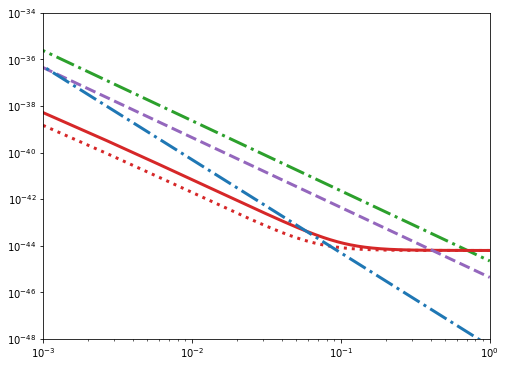

In [112]:
plt.figure(figsize=(8,6))
plt.loglog(a, rho_cr_in_gev4*rho_dm_a, color='tab:green', ls='-.', lw=3)
plt.loglog(a, rho_cr_in_gev4*rho_de_a, color='tab:red', ls='-', lw=3)
plt.loglog(a, rho_cr_in_gev4*rho_de_a_15, color='tab:red', ls=':', lw=3)
plt.loglog(a, rho_cr_in_gev4*rho_b_a, color='tab:purple', ls='--', lw=3)
plt.loglog(a, rho_cr_in_gev4*rho_r_a, color='tab:blue', ls='-.', lw=3)
plt.xlim([1e-3, 1])
plt.ylim([1e-48, 1e-34])

In [113]:
rho_tot_a = rho_r_a + rho_b_a + rho_dm_a + rho_de_a
f_r_a = rho_r_a/rho_tot_a
f_b_a = rho_b_a/rho_tot_a
f_dm_a = rho_dm_a/rho_tot_a
f_de_a = rho_de_a/rho_tot_a
f_de_a_15 = rho_de_a_15/rho_tot_a

(0.0, 0.9)

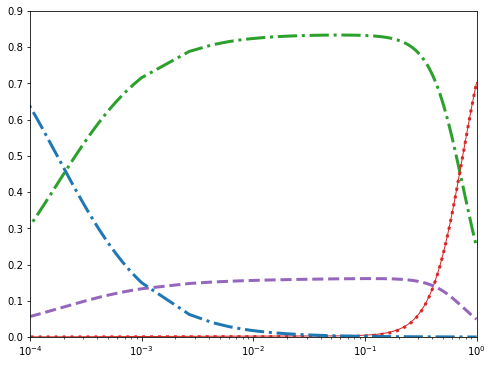

In [116]:
plt.figure(figsize=(8,6))
plt.semilogx(a, f_dm_a, color='tab:green', ls='-.', lw=3)
plt.semilogx(a, f_de_a, color='tab:red', ls='-', lw=1)
plt.semilogx(a, f_de_a_15, color='tab:red', ls=':', lw=3)
plt.semilogx(a, f_b_a, color='tab:purple', ls='--', lw=3)
plt.semilogx(a, f_r_a, color='tab:blue', ls='-.', lw=3)
plt.xlim([1e-4, 1])
plt.ylim([0, 0.9])